In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import tushare as ts
import time
from datetime import datetime, timedelta
import re
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from tqdm import notebook, trange
import matplotlib.pyplot as plt
import seaborn as sns


def affected_date(series: pd.Series, trade_dates: pd.Series, deadline='15:00:00'):
    """
    根据新闻的创建时间获得该新闻影响的交易日
    Args:
        deadline: 新闻归入当前交易日的截止时间
        series: 一条新闻
        trade_dates: 交易日序列

    Returns: 日期

    """
    date = series['date']
    _time = series['time']
    if (_time <= datetime.strptime(deadline, "%H:%M:%S").time()) and (date in trade_dates.to_list()):
        return date
    else:
        return trade_dates[trade_dates > series['create_time']].min()


def data_preprocess(path="./data/history_news.txt", deadline='15:00:00'):
    """
    读取数据，关联上证综指，并进行数据预处理。
    Args:
        deadline: 归入下一个交易日的截止时间
        path: 历史新闻保存路径

    Returns: DataFrame

    """
    print('Reading the history news data!')
    df = pd.read_csv(path, sep="#split#", engine='python', encoding='utf-8')
    df = df.drop(columns=['modified_time', 'news_content'])
    df = df.astype(
        {'create_time': 'datetime64', 'title': 'str', 'reading_num': 'int', 'share_num': 'int', 'recommend_num': 'int'})
    df = df[df['title'] != 'nan']
    df['date'] = df['create_time'].dt.date
    df['time'] = df['create_time'].dt.time
    pro = ts.pro_api('0d52800e5aed61cb4188bfde75dceff83fef0a928a0363a12a3c27d2')
    szzz = pro.index_daily(ts_code='000001.SH',
                           start_date=datetime.strftime(df['date'].min(), '%Y%m%d'),
                           end_date=datetime.strftime(datetime.today(), '%Y%m%d'))
    szzz = szzz[['trade_date', 'pct_chg']].astype({'trade_date': 'datetime64', 'pct_chg': 'float'})
    df['affected_date'] = df.apply(lambda x: affected_date(x, trade_dates=szzz['trade_date'], deadline=deadline),
                                   axis=1)
    df = df.merge(szzz, how='left', left_on='affected_date', right_on='trade_date').sort_values(by=['affected_date'], ascending=True)
    return df


def daily_filter(daily_df: pd.DataFrame, tokenizer: BertTokenizer, max_news_num: int, max_news_length: int):
    """
    对每个交易日的新闻进行indices，并保存每条新闻词的数量，以及当天上证综指涨跌幅/10
    Args:
        tokenizer:
        daily_df:
        max_news_num:
        max_news_length:

    Returns:

    """
    daily_df = daily_df.sort_values(by=['share_num', 'recommend_num', 'reading_num'], ascending=False)
    daily_df = daily_df[['create_time', 'title', 'reading_num', 'share_num', 'recommend_num', 'affected_date']]
    news_num = len(daily_df)
    daily_df = daily_df.iloc[:max_news_num, :]
    sentences = daily_df['title'].to_list()
    sentences = [re.sub(r"(\u3000|\n|\t|\r|：|)", "", sent) for sent in sentences]
    news_length = max([len(sent) for sent in sentences])
    input_ids = []
    att_masks = []
    for sent in sentences:
        encode_sent = tokenizer.encode(sent, add_special_tokens=True, padding='max_length',
                                       truncation='longest_first', max_length=max_news_length)
        input_ids.append(encode_sent)
        att_mask = [int(token_id > 0) for token_id in encode_sent]
        att_masks.append(att_mask)
    while len(input_ids) < max_news_num:
        input_ids.append([0] * max_news_length)
        att_masks.append([0] * max_news_length)
    return input_ids, att_masks, news_num, news_length


def generate_dataloader(input_ids, att_masks, labels, batch_size, shuffle=True):
    input_ids = torch.tensor(input_ids)
    att_masks = torch.tensor(att_masks)
    labels = torch.tensor(labels).float()
    data = TensorDataset(input_ids, att_masks, labels)
    if shuffle:
        sampler = RandomSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    else:
        dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return dataloader


def data_split(df, tokenizer, max_news_num, max_news_length, batch_size):
    """
    Spliting the DataFrame into training, validation and test. Encoding the texts by tokenizer,
    and create the masks and sentences length list at the same time.
    Args:
        df: Dataframe
        tokenizer: encoder tokenizer
        max_news_num: max sentence number
        max_news_length: max sentence length
        batch_size:

    Returns: Dataloader, sentences_length(inclouding training, validation and test)
    """
    print('Encoding texts by tokenizer, and splitting the dataset into training, valid and test......')
    news_num_list = []
    news_length_list = []
    train_input_ids = []
    valid_input_ids = []
    test_input_ids = []
    train_att_masks = []
    valid_att_masks = []
    test_att_masks = []
    train_labels = []
    valid_labels = []
    test_labels = []

    daily_df_list = [daily_df[1] for daily_df in df.groupby('affected_date')]
    for daily_df in daily_df_list:
        input_id, att_mask, news_num, news_length = daily_filter(daily_df, tokenizer=tokenizer,
                                                                 max_news_num=max_news_num,
                                                                 max_news_length=max_news_length)
        news_num_list.append(news_num)
        news_length_list.append(news_length)
        if daily_df['affected_date'].unique()[0] < np.datetime64('2020-01-01'):
            train_input_ids.append(input_id)
            train_att_masks.append(att_mask)
            train_labels.append(daily_df['pct_chg'].unique() / 10)
        elif daily_df['affected_date'].unique()[0] < np.datetime64('2020-07-01'):
            valid_input_ids.append(input_id)
            valid_att_masks.append(att_mask)
            valid_labels.append(daily_df['pct_chg'].unique() / 10)
        elif daily_df['affected_date'].unique()[0] < np.datetime64('2021-01-01'):
            test_input_ids.append(input_id)
            test_att_masks.append(att_mask)
            test_labels.append(daily_df['pct_chg'].unique() / 10)

    print("Maximum length of news's title is %s, we just take the first %s words." % (
        max(news_length_list), max_news_length))
    print("The day with the most news releases was %s, we just take the top %s." % (max(news_num_list), max_news_num))
    train_dataloader = generate_dataloader(train_input_ids, train_att_masks, train_labels, batch_size)
    valid_dataloader = generate_dataloader(valid_input_ids, valid_att_masks, valid_labels, batch_size)
    test_dataloader = generate_dataloader(test_input_ids, test_att_masks, test_labels, batch_size, shuffle=False)

    return train_dataloader, valid_dataloader, test_dataloader


def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(timedelta(seconds=elapsed_rounded))


def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, device):
    if load_path is None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path is None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, device):
    if load_path is None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


def training_history_plot(plt_save_path,train_loss_list, valid_loss_list, global_steps_list):
    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.title('Training and Validation loss of the model')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plt_save_path + 'loss.png')
    plt.show()
    print('The training and valid loss curves have already saved to ==> {plt_save_path}')


def train(model, optimizer, scheduler, epochs, train_dataloader, valid_dataloader, device, save_file_path='./training_information'):
    print('Start training the model!')
    best_valid_loss = float("Inf")
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')
        t0 = time.time()
        total_loss = 0
        model.train()
        for step, train_batch in enumerate(train_dataloader):
            if step % 10 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print("\r", 'Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed), end="",flush=True)
            train_batch = tuple(inp.to(device) for inp in train_batch)
            input_ids, input_mask, label_ids = train_batch
            del train_batch
            y_predict = model(input_ids, input_mask)
            loss = torch.nn.functional.mse_loss(y_predict, label_ids)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            # clip the norm of the gradients to 1.0, to help prevent the "exploding gradients".
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_list.append(avg_train_loss)
        print("")
        print(" Average training loss: {0:.5f}".format(avg_train_loss))
        print(" Training epoch took: {:}".format(format_time(time.time() - t0)))

        print("")
        print("Running Validation...")
        t0 = time.time()
        model.eval()
        total_loss = 0
        nb_eval_steps, nb_eval_examples = 0, 0
        for step, valid_batch in enumerate(valid_dataloader):
            valid_batch = tuple(inp.to(device) for inp in valid_batch)
            input_ids, input_mask, label_ids = valid_batch
            with torch.no_grad():
                y_predict = model(input_ids, input_mask)
                loss = torch.nn.functional.mse_loss(y_predict, label_ids)
            total_loss += loss.item()
        avg_valid_loss = total_loss / len(valid_dataloader)
        valid_loss_list.append(avg_valid_loss)
        print(" Average validation loss: {0:.5f}".format(avg_valid_loss))
        print(" Validation epoch took: {:}".format(format_time(time.time() - t0)))

        if best_valid_loss > avg_valid_loss:
            best_valid_loss = avg_valid_loss
            save_checkpoint(save_file_path + '/model.pt', model, best_valid_loss)
            save_metrics(save_file_path + '/metrics.pt', train_loss_list, valid_loss_list,  range(epochs))
    save_metrics(save_file_path + '/metrics.pt', train_loss_list, valid_loss_list, range(epochs))
    training_history_plot(save_file_path, train_loss_list, valid_loss_list, range(epochs))
    print("")
    print("Training complete!")


def evaluate(model, test_dataloader, device, save_file_path='./training_information'):
    print('Predicting returns on that day based on news begin on July 1, 2020.')
    # Put model in evaluation mode
    model.eval()
    # Tracking variables
    total_loss = 0
    pred_y, true_y = np.array([]), np.array([])
    # Predict
    for _, test_batch in enumerate(test_dataloader):
        batch = tuple(inp.to(device) for inp in test_batch)
        input_ids, input_mask, label_ids = batch
        with torch.no_grad():
            y_pred = model(input_ids, input_mask)
            loss = torch.nn.functional.mse_loss(y_pred, label_ids)
        total_loss += loss.item()
        y_pred = y_pred.cpu().numpy()*10
        label_ids = label_ids.cpu().numpy()*10
        pred_y = np.append(pred_y, y_pred)
        true_y = np.append(true_y, label_ids)

    print("  Average test loss: {0:.2f}".format(total_loss / len(test_dataloader)))
    print('DONE.')
    pro = ts.pro_api('0d52800e5aed61cb4188bfde75dceff83fef0a928a0363a12a3c27d2')
    szzz = pro.index_daily(ts_code='000001.SH', start_date='20200701', end_date='20210101')
    szzz = szzz[['trade_date', 'close', 'pct_chg']].astype({'trade_date': 'datetime64', 'close':'float', 'pct_chg': 'float'})
    szzz = szzz.sort_values(by=['trade_date'], ascending=True)
    szzz['predict'] = pred_y
    szzz['true_pct_chg'] = true_y
    szzz['diff'] = (szzz['predict'] - szzz['true_pct_chg']).abs()
    szzz.to_excel(save_file_path+'/predict.xlsx', index=False)
    max_date = szzz[['trade_date','predict','true_pct_chg','diff']].loc[np.abs(szzz['diff']).idxmax(),:]
    diff_info = szzz['diff'].describe()

    my_dpi = 120
    fig, ax1 = plt.subplots(figsize=(1000 / my_dpi, 600 / my_dpi), dpi=my_dpi)
    ax2 = ax1.twinx()
    ax1.plot(szzz['trade_date'], szzz['predict'], label='predict', color='red')
    ax1.plot(szzz['trade_date'], szzz['true_pct_chg'], label='true', color='blue')
    ax1.vlines(max_date['trade_date'], ymin=szzz['diff'].min(), ymax=szzz['diff'].max(), color='green')
    ax1.text(x=max_date['trade_date'], y=szzz['diff'].min()*0.8, s='residual_max'+str(round(max_date['diff'],2)), color='gray')

    ax1.hlines(diff_info['mean'], xmin=szzz['trade_date'].min(), xmax=szzz['trade_date'].max(), color='green')
    ax1.text(x=szzz['trade_date'].max(), y=diff_info['mean'], s='residual_mean'+str(round(diff_info['mean'],2)), color='green')
    ax1.hlines(diff_info['25%'], xmin=szzz['trade_date'].min(), xmax=szzz['trade_date'].max(), color='green')
    ax1.text(x=szzz['trade_date'].max(), y=diff_info['25%'], s='residual_lower_quartile'+str(round(diff_info['25%'],2)), color='green')
    ax1.hlines(diff_info['75%'], xmin=szzz['trade_date'].min(), xmax=szzz['trade_date'].max(), color='green')
    ax1.text(x=szzz['trade_date'].max(), y=diff_info['75%'], s='residual_upper_quartile'+str(round(diff_info['75%'],2)), color='green')

    ax2.plot(szzz['trade_date'], szzz['close'], label='szzz', color='black')
    plt.title('The predict and true return of szzz from July 1, 2020')
    ax1.set_xlabel('')
    ax1.set_ylabel('Return(%)')
    ax2.set_ylabel('SH.000001')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.savefig(save_file_path+'/evalution.png')
    plt.show()

In [2]:
from pytorch_transformers import BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F


class FinBertTransformer(nn.Module):
    def __init__(self, pretrain_path='./pretrained_models/FinBERT_L-12_H-768_A-12_pytorch',
                 sents_num=50, sent_hidden=[96, 24], nhead=8, num_layers=6, news_hidden=[24, 1]):
        super(FinBertTransformer, self).__init__()
        self.sents_num = sents_num
        self.sent_hidden = sent_hidden
        self.pretrain_model = BertModel.from_pretrained(pretrain_path)
        transform_encoderlayer = nn.TransformerEncoderLayer(d_model=sent_hidden[1], nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transform_encoderlayer, num_layers=num_layers)
        self.sh_fc1 = nn.Linear(768, sent_hidden[0])
        self.sh_dropout1 = nn.Dropout(0.2)
        self.sh_fc2 = nn.Linear(sent_hidden[0], sent_hidden[1])
        self.sh_dropout2 = nn.Dropout(0.2)
        self.nh_fc1 = nn.Linear(sent_hidden[1] * sents_num, news_hidden[0])
        self.nh_dropout1 = nn.Dropout(0.2)
        self.nh_fc2 = nn.Linear(news_hidden[0], news_hidden[-1])
        self.nh_dropout2 = nn.Dropout(0.2)
        if news_hidden[-1] > 1:
            self.act = F.softmax
        else:
            self.act = torch.tanh

    def forward(self, x, mask=None):
        x = x.view(-1, x.shape[-1])
        if mask is not None:
            mask = mask.view(-1, mask.shape[-1])
        last_hidden, pooler_output = self.pretrain_model(
            x, attention_mask=mask)
        x = pooler_output.view(-1, self.sents_num, 768)
        x = F.relu(self.sh_fc1(self.sh_dropout1(x)))
        x = F.relu(self.sh_fc2(self.sh_dropout2(x)))
        x = self.transformer_encoder(x)
        x = x.view(-1, self.sents_num * self.sent_hidden[-1])
        x = F.relu(self.nh_fc1(self.nh_dropout1(x)))
        x = self.act(self.nh_fc2(self.nh_dropout2(x)))
        return x

In [3]:
import os
import sys
import time
import numpy as np
import joblib
from tqdm import notebook, trange
import re
import random
import torch
from torch.nn.utils import clip_grad_norm_
from transformers import BertTokenizer, AdamW
from transformers import get_linear_schedule_with_warmup

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPu:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPu: GeForce RTX 3090


In [4]:
SEED = 333
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 100
BATCH_SIZE = 16
MAX_NEWS_LENGTH = 60
MAX_NEWS_NUM = 20
EPSILION = 1e-8
LEARNING_RATE = 2e-5

In [5]:
df = data_preprocess(path="./work/data/history_news.txt", deadline='15:00:00')
model_path = './work/pretrained_models/FinBERT_L-12_H-768_A-12_pytorch'
print('Loading BERT tokenizer from <==', model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
train_dataloader, valid_dataloader, test_dataloader = data_split(df, tokenizer=tokenizer,
                                                                 max_news_num=MAX_NEWS_NUM,
                                                                 max_news_length=MAX_NEWS_LENGTH,
                                                                 batch_size=BATCH_SIZE)
del df
print('Building the model and load pre-trained parameters from <==', model_path)
model = FinBertTransformer(pretrain_path=model_path, sents_num=MAX_NEWS_NUM, sent_hidden=[96, 24],
                           nhead=8, num_layers=6, news_hidden=[12, 1])
model.to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILION)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Reading the history news data!
Loading BERT tokenizer from <== ./work/pretrained_models/FinBERT_L-12_H-768_A-12_pytorch
Encoding texts by tokenizer, and splitting the dataset into training, valid and test......
Maximum length of news's title is 59, we just take the first 60 words.
The day with the most news releases was 2211, we just take the top 20.
Building the model and load pre-trained parameters from <== ./work/pretrained_models/FinBERT_L-12_H-768_A-12_pytorch


Start training the model!

======== Epoch 1 / 100 ========
Training...
 Batch    80 of    88. Elapsed: 0:00:47.
 Average training loss: 0.03153
 Training epoch took: 0:00:51

Running Validation...
 Average validation loss: 0.01768
 Validation epoch took: 0:00:01
Model saved to ==> ./work/training_information/model.pt
Model saved to ==> ./work/training_information/metrics.pt

======== Epoch 2 / 100 ========
Training...
 Batch    80 of    88. Elapsed: 0:00:47.
 Average training loss: 0.02388
 Training epoch took: 0:00:52

Running Validation...
 Average validation loss: 0.01836
 Validation epoch took: 0:00:01

======== Epoch 3 / 100 ========
Training...
 Batch    80 of    88. Elapsed: 0:00:47.
 Average training loss: 0.02386
 Training epoch took: 0:00:52

Running Validation...
 Average validation loss: 0.01960
 Validation epoch took: 0:00:01

======== Epoch 4 / 100 ========
Training...
 Batch    80 of    88. Elapsed: 0:00:48.
 Average training loss: 0.02357
 Training epoch took: 0:00:52



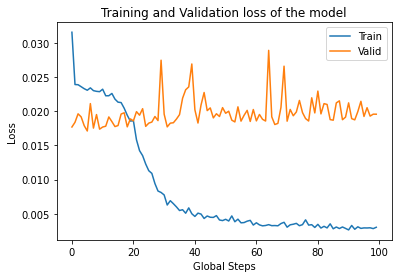

The training and valid loss curves have already saved to ==> {plt_save_path}

Training complete!


In [6]:
train(model=model, optimizer=optimizer, scheduler=scheduler, epochs=EPOCHS, train_dataloader=train_dataloader, 
      valid_dataloader=valid_dataloader, device=device, save_file_path='./work/training_information')

Predicting returns on that day based on news begin on July 1, 2020.
  Average test loss: 0.02
DONE.


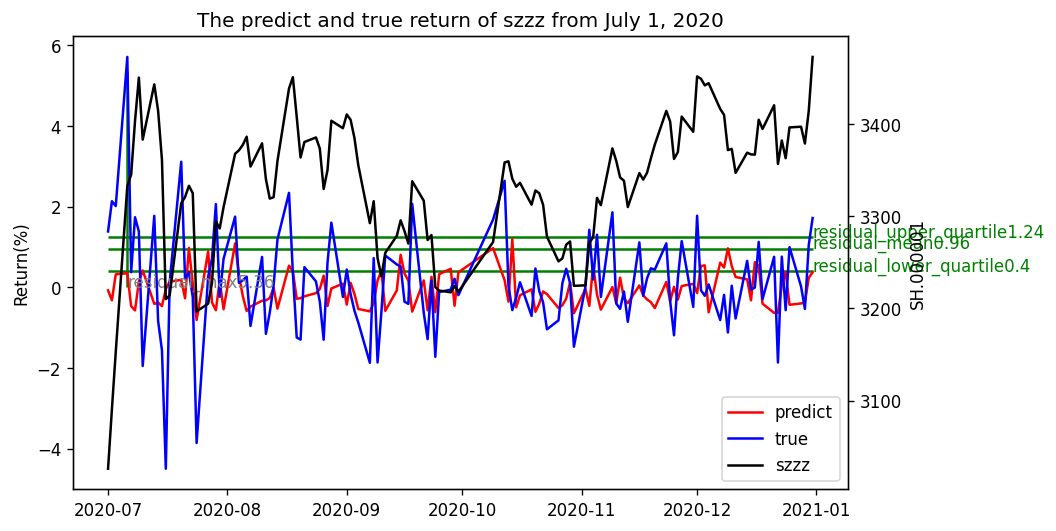

In [7]:
evaluate(model=model, test_dataloader=test_dataloader, device=device, save_file_path='./work/training_information')